#### woba value by pitch type and zone

In [4]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/Active/Swing Decisons')

In [5]:
df = pd.read_csv('./data/swing_data/pitch_21_24.csv')

#### Grouping by Pitch Type

In [6]:
df['game_date'] = pd.to_datetime(df['game_date']).dt.year

In [7]:
df = df[df['pitch_name'] != 'Pitch Out']

In [8]:
pitch_groups = {
    'curveballs': ['Curveball', 'Knuckle Curve', 'Slow Curve'],
    'sliders_sweepers': ['Slider', 'Sweeper', 'Slurve'],
    'screwball': ['Screwball'],

    'split_grip': ['Split-Finger', 'Forkball'],
    'changeups': ['Changeup'],

    'four_seam': ['4-Seam Fastball'],
    'sinkers': ['Sinker'],
    'cutters': ['Cutter']
}
# in the df pitch name col change pitch names to this dicty above
def map_pitch_group(pitch):
    for group, names in pitch_groups.items():
        if pitch in names:
            return group
    return 'other'

df['pitch_group'] = df['pitch_name'].apply(map_pitch_group)

#### Adding Ball of Strike

In [9]:
# create a new col called pos_s_b where if the plate vert is between sz_bot and sz_top for the row
# and the plate_horz is between -.70833 and .70833 it is a strike, else it is a ball
df['pos_strike_ball'] = df.apply(
    lambda row: 'strike' if (row['sz_bot'] <= row['plate_vert'] <= row['sz_top'] and -0.833333 <= row['plate_horz'] <= 0.83333) else 'ball',
    axis=1
)

#### woba value for strike and ball
woba following each count, for 2-1 count average of 3-1, 3-2, 2-2

In [10]:
# Create a 'count' column as a string, e.g., '2-1'
df['count'] = df['balls'].astype(str) + '-' + df['strikes'].astype(str)

# Manually define the next_counts mapping for all possible counts (balls-strikes)
next_counts = {
    '0-0': ['0-0', '0-1', '0-2', '1-0', '1-1', '1-2', '2-0', '2-1', '2-2', '3-0', '3-1', '3-2'],
    '0-1': ['0-1', '0-2', '1-1', '1-2', '2-1', '2-2', '3-1', '3-2'],
    '0-2': ['0-2', '1-2', '2-2', '3-2'],
    '1-0': ['1-0', '1-1', '1-2', '2-0', '2-1', '2-2', '3-0', '3-1', '3-2'],
    '1-1': ['1-1', '1-2', '2-1', '2-2', '3-1', '3-2'],
    '1-2': ['1-2', '2-2', '3-2'],
    '2-0': ['2-0', '2-1', '2-2', '3-0', '3-1', '3-2'],
    '2-1': ['2-1', '2-2', '3-1', '3-2'],
    '2-2': ['2-2', '3-2'],
    '3-0': ['3-0', '3-1', '3-2'],
    '3-1': ['3-1', '3-2'],
    '3-2': ['3-2'],
}


mean_xwoba_by_count = df.groupby(['count']).agg(
    xwoba=('xwoba', 'mean'),
    amount=('count', 'size')
).reset_index()
mean_xwoba_by_count = mean_xwoba_by_count[mean_xwoba_by_count['amount'] > 100]



In [11]:
# For each count, calculate the weighted mean of the next counts' xwoba using the 'amount' column as weights
mean_next_xwoba = {}
for count, nexts in next_counts.items():
    values = [(mean_xwoba_by_count.loc[mean_xwoba_by_count['count'] == n, 'xwoba'].values[0], 
               mean_xwoba_by_count.loc[mean_xwoba_by_count['count'] == n, 'amount'].values[0]) 
              for n in nexts if n in mean_xwoba_by_count['count'].values]
    if values:
        total_weight = sum(weight for _, weight in values)
        mean_next_xwoba[count] = sum(xwoba * weight for xwoba, weight in values) / total_weight if total_weight > 0 else np.nan
    else:
        mean_next_xwoba[count] = np.nan

# Convert to DataFrame for easier viewing
mean_next_xwoba_df = pd.DataFrame(list(mean_next_xwoba.items()), columns=['count', 'mean_next_xwoba'])
mean_next_xwoba_df
   


,count,mean_next_xwoba
0,0-0,0.340948
1,0-1,0.300907
2,0-2,0.213489
3,1-0,0.333902
4,1-1,0.303436
5,1-2,0.227184
6,2-0,0.353180
7,2-1,0.327008
8,2-2,0.262021
9,3-0,0.461848


Text(0.5, 1.0, 'Expected xwOBA by Count')

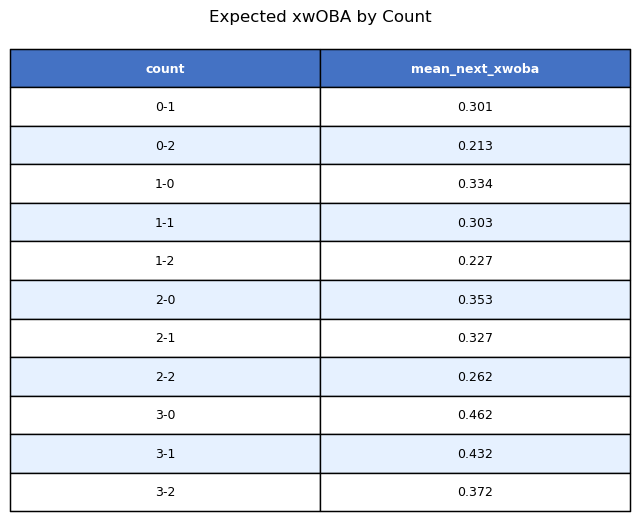

In [12]:
mean_next_xwoba_dfp = mean_next_xwoba_df.drop(0, axis=0)
# Create figure and axis with specific size
fig, ax = plt.subplots(figsize=(8, 6))

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Create table
table = ax.table(
    cellText=mean_next_xwoba_dfp.round(3).values,
    colLabels=mean_next_xwoba_dfp.columns,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

# Color header
for k, cell in table._cells.items():
    if k[0] == 0:  # Header
        cell.set_facecolor('#4472C4')
        cell.set_text_props(weight='bold', color='white')
    else:  # Data cells
        cell.set_facecolor('#E6F1FF' if k[0] % 2 == 0 else 'white')

plt.title('Expected xwOBA by Count', pad=20)


#### Pitch Attack Zones

In [13]:
# Assume 'df' is your DataFrame
# Pre-calculate bounds for clarity and slight efficiency
vert_bounds = [
    df['sz_top'] * 0.7744, # Lower bound for zones 1, 2, 3 # 0
    df['sz_top'] * 0.9,    # Upper bound for zones 1, 2, 3, bottom for chase
    df['sz_top'] * 0.6488, # Lower bound for zones 4, 5, 6
    df['sz_top'] * 0.7744, # Upper bound for zones 4, 5, 6 (same as lower for 1,2,3)
    df['sz_top'] * 0.5232, # Lower bound for zones 7, 8, 9, top for cgase zibe
    df['sz_top'] * 0.6488, # Upper bound for zones 7, 8, 9 (same as lower for 4,5,6)
    df['sz_top'] * 1.1, # top for chase zone,
    df['sz_top'] * .333 # bottom for chase zone 
]
horz_bounds = [
    -6.7 / 12, #0
    -2.2333 / 12,
    2.2333 / 12,
    6.7 / 12,
    -13.3/12, #4
    -7.98/12,
    -2.66/12,
    2.66/12, #7
    7.98/12,
    13.3/12,
    0
]

# Define the conditions using vectorized comparisons on columns
conditions = [
    (vert_bounds[0] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[1]) & (horz_bounds[0] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[1]), # Zone 1
    (vert_bounds[0] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[1]) & (horz_bounds[1] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[2]), # Zone 2
    (vert_bounds[0] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[1]) & (horz_bounds[2] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[3]), # Zone 3
    (vert_bounds[2] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[3]) & (horz_bounds[0] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[1]), # Zone 4
    (vert_bounds[2] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[3]) & (horz_bounds[1] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[2]), # Zone 5
    (vert_bounds[2] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[3]) & (horz_bounds[2] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[3]), # Zone 6
    (vert_bounds[4] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[5]) & (horz_bounds[0] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[1]), # Zone 7
    (vert_bounds[4] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[5]) & (horz_bounds[1] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[2]), # Zone 8
    (vert_bounds[4] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[5]) & (horz_bounds[2] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[3]), # Zone 9

    (vert_bounds[1] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[6]) & (horz_bounds[4] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[5]), # Zone 10
    (vert_bounds[1] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[6]) & (horz_bounds[5] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[6]), # Zone 11
    (vert_bounds[1] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[6]) & (horz_bounds[6] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[7]), # Zone 12
    (vert_bounds[1] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[6]) & (horz_bounds[7] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[8]), # Zone 13
    (vert_bounds[1] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[6]) & (horz_bounds[8] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[9]), # Zone 14

    (vert_bounds[7] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[4]) & (horz_bounds[4] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[5]), # Zone 15
    (vert_bounds[7] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[4]) & (horz_bounds[5] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[6]), # Zone 16
    (vert_bounds[7] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[4]) & (horz_bounds[6] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[7]), # Zone 17
    (vert_bounds[7] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[4]) & (horz_bounds[7] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[8]), # Zone 18
    (vert_bounds[7] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[4]) & (horz_bounds[8] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[9]), # Zone 19

    (vert_bounds[4] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[2]) & (horz_bounds[3] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[9]), # Zone 20
    (vert_bounds[2] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[0]) & (horz_bounds[3] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[9]), # Zone 21
    (vert_bounds[0] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[1]) & (horz_bounds[3] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[9]), # Zone 22

    (vert_bounds[4] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[2]) & (horz_bounds[4] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[0]), # Zone 23
    (vert_bounds[2] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[0]) & (horz_bounds[4] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[0]), # Zone 24
    (vert_bounds[0] <= df['plate_vert']) & (df['plate_vert'] <= vert_bounds[1]) & (horz_bounds[4] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[0]), # Zone 25

    (df['plate_horz'] <= horz_bounds[4]) & (df['plate_vert'] <= vert_bounds[2]), # Zone 26
    (df['plate_horz'] <= horz_bounds[4]) & (df['plate_vert'] > vert_bounds[2]), # Zone 27

    (vert_bounds[6] <= df['plate_vert']) & (horz_bounds[4] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[10]), #28
    (vert_bounds[6] <= df['plate_vert']) & (df['plate_horz'] >= horz_bounds[0]) & (df['plate_horz'] <= horz_bounds[9]), # Zone 29
    (horz_bounds[4] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[10]) & (df['plate_vert'] <= vert_bounds[2]), # Zone 30

    (df['plate_horz'] >= horz_bounds[9]) & (df['plate_vert'] >= vert_bounds[2]), # 31
    (df['plate_horz'] >= horz_bounds[9]) & (df['plate_vert'] <= vert_bounds[2]), # 32

    (vert_bounds[7] >= df['plate_vert']) & (horz_bounds[4] <= df['plate_horz']) & (df['plate_horz'] <= horz_bounds[9]) # Zone 33


    
]

# Define the corresponding values for each condition
choices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 ,12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

df['nzone'] = np.select(conditions, choices, default=0) 

#### Pitches in Zone Plotted

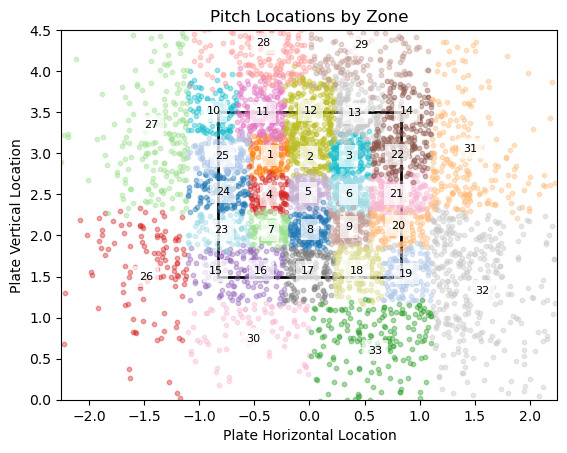

In [14]:
import random

strike_zone_left = -0.833  # -10 inches in feet
strike_zone_right = 0.833  # +10 inches in feet
strike_zone_top = 3.5
strike_zone_bottom = 1.5

# Plot the strike zone as a rectangle
plt.gca().add_patch(
    plt.Rectangle(
        (strike_zone_left, strike_zone_bottom),
        strike_zone_right - strike_zone_left,
        strike_zone_top - strike_zone_bottom,
        fill=False, edgecolor='black', linewidth=2, linestyle='-', label='Strike Zone'
    )
)


df_judge = df[df['batter'] == 'mike trout']

unique_zones = sorted(df_judge['nzone'].unique())
cmap = plt.get_cmap('tab20', len(unique_zones))

# Shuffle color assignments to maximize contrast between adjacent zones
shuffled_indices = list(range(len(unique_zones)))
random.seed(987654)  # For reproducibility
random.shuffle(shuffled_indices)
zone_colors = {zone: cmap(shuffled_indices[i]) for i, zone in enumerate(unique_zones)}

for zone in unique_zones:
    subset = df_judge[df_judge['nzone'] == zone]
    plt.scatter(
        subset['plate_horz'], subset['plate_vert'],
        color=zone_colors[zone], label=f'Zone {zone}',
        alpha=0.4, s=10
    )

plt.xlabel('Plate Horizontal Location')
plt.ylabel('Plate Vertical Location')
plt.ylim(0, 4.5)
plt.xlim(-2.25, 2.25)
# Calculate and add text annotations for each zone
for zone in unique_zones:
    subset = df_judge[df_judge['nzone'] == zone]
    if len(subset) > 0:
        # Calculate average position for each zone
        avg_x = subset['plate_horz'].mean()
        avg_y = subset['plate_vert'].mean()
        # Add text with zone number
        plt.text(avg_x, avg_y, str(zone), fontsize=8, ha='center', va='center', 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
plt.title('Pitch Locations by Zone')
plt.show()


#### groupby pitch and zone
the xwoba value of swinging at a pitch in a zone by batter

In [15]:
df['zone'] = df['nzone']
df['description'].unique()

array(['swinging_strike_blocked', 'swinging_strike', 'ball', 'foul',
       'called_strike', 'hit_into_play', 'blocked_ball', 'foul_tip',
       'foul_bunt', 'hit_by_pitch', 'missed_bunt', 'bunt_foul_tip'],
      dtype=object)

In [16]:
df_play = df[(df['description'] == 'swinging_strike') 
             | (df['description'] == 'swinging_strike_blocked') | 
             (df['description'] == 'hit_into_play') ]
df_play['xwoba'] = df_play['xwoba'].fillna(0)
df_play = df_play[df_play['pitch_group'] != 'other']

C:\Users\dalto\AppData\Local\Temp\ipykernel_25624\330885727.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_play['xwoba'] = df_play['xwoba'].fillna(0)


In [17]:
df_left = df_play[df_play['b_stands'] != 'R']
df_right = df_play[df_play['b_stands'] != 'L']

In [18]:
woba_zone_pitch_countL = df_left.groupby(['zone', 'pitch_group'])['xwoba'].mean()
woba_zone_pitch_countL = woba_zone_pitch_countL.to_frame().reset_index()
woba_zone_pitch_countL['instances'] = df_left.groupby(['zone', 'pitch_group'])['xwoba'].count().values
woba_zone_pitch_countL = woba_zone_pitch_countL.reset_index()

In [19]:
woba_zone_pitch_countR = df_right.groupby(['zone', 'pitch_group'])['xwoba'].mean()
woba_zone_pitch_countR = woba_zone_pitch_countR.to_frame().reset_index()
woba_zone_pitch_countR['instances'] = df_right.groupby(['zone', 'pitch_group'])['xwoba'].count().values
woba_zone_pitch_countR = woba_zone_pitch_countR.reset_index()

### Mapping to df 

In [20]:
df_results = df.copy()
df_results = df_results.drop(columns=['Unnamed: 0', 'pitch_type', 'pitch_name', 'plate_horz', 'plate_vert','sz_top','sz_bot'])

In [21]:
# Map the xwoba value from woba_zone_pitch_countL to df for left-handed batters
woba_zone_pitch_countL_keyed = woba_zone_pitch_countL.set_index(['pitch_group', 'zone'])['xwoba']

mask_left = df['b_stands'] == 'L'
df_results.loc[mask_left, 'zone_pitch_xwoba'] = df_results.loc[mask_left].apply(
    lambda row: woba_zone_pitch_countL_keyed.get((row['pitch_group'], row['zone']), np.nan), axis=1
)


woba_zone_pitch_countR_keyed = woba_zone_pitch_countR.set_index(['pitch_group', 'zone'])['xwoba']

mask_right = df['b_stands'] == 'R'
df_results.loc[mask_right, 'zone_pitch_xwoba'] = df_results.loc[mask_right].apply(
    lambda row: woba_zone_pitch_countR_keyed.get(( row['pitch_group'], row['zone']), np.nan), axis=1
)

add in if batter swing or take

In [22]:
swing = {'swing':['foul_tip', 'foul', 'hit_into_play', 'swinging_strike', 'swinging_strike_blocked']}
# add a new col in df_results called swing, if description == anything in swing dict make value of col Y if not make it n
df_results['swing'] = df_results['description'].apply(lambda x: 'Y' if x in swing['swing'] else 'N')

count + 1 ev, so if you take the pitch what is expected woba from there

In [23]:
# Create a new column 'count_next' based on 'type'
def get_next_count(row):
    balls, strikes = row['balls'], row['strikes']
    if row['pos_strike_ball'] == 'strike':
        # Add a strike, but max 2 strikes before next pitch
        strikes_next = min(strikes + 1, 2) if (balls < 4 and strikes < 2) else strikes + 1
        return f"{balls}-{strikes_next}"
    elif row['pos_strike_ball'] == 'ball':
        # Add a ball, but max 3 balls before next pitch
        balls_next = min(balls + 1, 3) if (balls < 3 and strikes < 3) else balls + 1
        return f"{balls_next}-{strikes}"
    else:
        return f"{balls}-{strikes}"

df_results['count_next'] = df_results.apply(get_next_count, axis=1)

add expected woba after

In [24]:
df_results['exp_woba_after'] = df_results['count_next'].map(dict(zip(mean_next_xwoba_df['count'], mean_next_xwoba_df['mean_next_xwoba'])))

In [25]:
df_results.loc[df_results['count_next'].str.endswith('-3'), 'exp_woba_after'] = 0
df_results.loc[df_results['count_next'].str.startswith('4-'), 'exp_woba_after'] = 0.690
df_results = df_results[(df_results['exp_woba_after'] != 0) & (df_results['exp_woba_after'] != 0.69)]

In [26]:
df_results['swing_value'] = df_results['zone_pitch_xwoba'] - df_results['exp_woba_after']

### Analysis

In [27]:
df_swing_value = df_results[['game_date', 'pitcher', 'batter', 'pitch_group', 'pos_strike_ball', 'count', 'count_next', 'zone_pitch_xwoba', 'swing', 'exp_woba_after', 'swing_value', 'zone']]

#### split into different zones

In [28]:
df_swing_value_chase_heart = df_swing_value[df_swing_value['zone'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 ,12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])]
df_swing_value_chase_shadow = df_swing_value[df_swing_value['zone'].isin([10, 11 ,12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])]                         

In [38]:
df_swing_value_chase_heart = df_swing_value_chase_heart[df_swing_value_chase_heart['pos_strike_ball'] == 'strike']

In [30]:
#df_swing_value_chase_shadow = df_swing_value_chase_shadow[df_swing_value_chase_shadow['game_date'] == 2024]

value by zone

In [39]:
full_stats = pd.DataFrame()

In [40]:
# Calculate sum of zone_pitch_xwoba for swings and exp_woba_after for takes, then average per batter
batter_stats = df_swing_value_chase_shadow.groupby(['batter', 'game_date']).apply(
    lambda g: pd.Series({
        'sum_value': g.loc[g['swing'] == 'Y', 'zone_pitch_xwoba'].sum() + g.loc[g['swing'] == 'N', 'exp_woba_after'].sum(),
        'num_pitches': len(g)
    })
)

# average sum value
batter_stats['chase_shadow_value'] = batter_stats['sum_value'] / batter_stats['num_pitches']
batter_stats = batter_stats[(batter_stats['num_pitches'] > 50)].reset_index()

# Standardize Value
yearly_mean = batter_stats.groupby('game_date')['chase_shadow_value'].mean()
batter_stats['chase_shadow_value'] = batter_stats.apply(
    lambda row: (row['chase_shadow_value'] / yearly_mean[row['game_date']]) * 100, axis=1)

batter_stats = batter_stats[['batter', 'game_date', 'chase_shadow_value']]


C:\Users\dalto\AppData\Local\Temp\ipykernel_25624\4181453835.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  batter_stats = df_swing_value_chase_shadow.groupby(['batter', 'game_date']).apply(


In [41]:
full_stats = batter_stats.copy()

In [42]:
# Calculate sum of zone_pitch_xwoba for swings and exp_woba_after for takes, then average per batter
batter_stats1 = df_swing_value_chase_heart.groupby(['batter', 'game_date']).apply(
    lambda g: pd.Series({
        'sum_value': g.loc[g['swing'] == 'Y', 'zone_pitch_xwoba'].sum() + g.loc[g['swing'] == 'N', 'exp_woba_after'].sum(),
        'num_pitches': len(g)
    })
)

# average sum value
batter_stats1['chase_heart_value'] = batter_stats1['sum_value'] / batter_stats1['num_pitches']
batter_stats1 = batter_stats1[ (batter_stats1['num_pitches'] > 50)].reset_index()

# Standardize Value
yearly_mean1 = batter_stats1.groupby('game_date')['chase_heart_value'].mean()
batter_stats1['chase_heart_value'] = batter_stats1.apply(
    lambda row: (row['chase_heart_value'] / yearly_mean1[row['game_date']]) * 100, axis=1)

batter_stats1 = batter_stats1[['batter', 'game_date', 'chase_heart_value']]

full_stats = full_stats.merge(batter_stats1, how='outer', on=['batter', 'game_date'])

C:\Users\dalto\AppData\Local\Temp\ipykernel_25624\492408953.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  batter_stats1 = df_swing_value_chase_heart.groupby(['batter', 'game_date']).apply(


In [43]:
# Calculate sum of zone_pitch_xwoba for swings and exp_woba_after for takes, then average per batter
batter_stats = df_swing_value.groupby(['batter', 'game_date']).apply(
    lambda g: pd.Series({
        'sum_value': g.loc[g['swing'] == 'Y', 'zone_pitch_xwoba'].sum() + g.loc[g['swing'] == 'N', 'exp_woba_after'].sum(),
        'swing_value': g.loc[g['swing'] == 'Y', 'swing_value'].sum() - g.loc[g['swing'] == 'N', 'swing_value'].sum(),
        'num_pitches': len(g)
    })
)

# average sum value
batter_stats['overall_value'] = batter_stats['sum_value'] / batter_stats['num_pitches']
batter_stats = batter_stats[(batter_stats['num_pitches'] > 100)].reset_index()
batter_stats['swing_value'] = batter_stats['swing_value'] / batter_stats['num_pitches']
batter_stats['overall_value'] = batter_stats['overall_value'] * 100
batter_stats['swing_value'] = batter_stats['swing_value'] * 100

# Standardize Value
yearly_mean = batter_stats.groupby('game_date')['overall_value'].mean()
batter_stats['overall_value'] = batter_stats.apply(
    lambda row: (row['overall_value'] / yearly_mean[row['game_date']]) * 100, axis=1)

# Standardize Value
yearly_mean = batter_stats.groupby('game_date')['swing_value'].mean()
batter_stats['swing_value'] = batter_stats.apply(
    lambda row: (row['swing_value'] / yearly_mean[row['game_date']]) * 100, axis=1)


batter_stats = batter_stats[['batter', 'game_date', 'overall_value', 'swing_value']]
full_stats = full_stats.merge(batter_stats, how='outer', on=['batter', 'game_date'])

C:\Users\dalto\AppData\Local\Temp\ipykernel_25624\314155830.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  batter_stats = df_swing_value.groupby(['batter', 'game_date']).apply(


In [44]:
full_stats = full_stats.dropna()

#### Merge

In [45]:
# Combine merged_batter_stats with batter_stats
batter_stats = full_stats.copy()

#### Export / Standardize

In [47]:
batter_stats.to_csv('./data/stat_values/swing_values.csv')